# CAB420 DCNNs, Bonus Example: Fine Tuning using Keras Applications
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

This is another look at fine-tuning, but this time using the large pre-trained models in [Keras Applications](https://keras.io/api/applications/). This is a collection of models that have been trained on very large datasets (like ImageNet) that we can then download, modify, and re-train for our own tasks. 

This approach, of grabbing a large pre-trained model and fine-tuning to your own task, is extremely common when applying these methods. Training from scratch is usually not practical due to a combination of not enough data and not enough compute power.

There are a number of things you can consider when fine-tuning these models, and for those interested a much more comprehensive guide is available [here](https://keras.io/guides/transfer_learning/).

### Where does this fit into all the other CAB420 content?

This really builds directly on the week 5 content, and is just another example of fine-tuning. It's also (kind-of) the next logical example after the TFDS primer, as I'm going to use TFDS to load the data.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf
import keras
from keras import layers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import cv2

tf.config.optimizer.set_jit(False)

### Loading a Dataset

I'm going to just do exactly what was done in `CAB420_DCNNs_Bonus_Example_Tensorflow_Dataset_API.ipynb`, and just use the rock, paper, ~~shotgun~~ scissors dataset.

In [2]:
(ds_train, ds_val, ds_test), ds_info = tfds.load('rock_paper_scissors',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

# resize and rescaling operations
resize_and_rescale = keras.Sequential([
  layers.Resizing(96, 96),
  layers.Rescaling(1./255)
])

# augmentation operations
augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom((-0.1, 0.1)),
])

# function to apply rescaling and augmentation (if wanted)
def prepare_ds(ds, augment=False):

    # apply preprocessing (resizing and rescale)
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

    # Use data augmentation only if requested
    if augment:
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    
    return ds

# function to apply batching and prefecting
# This could very easily be part of the "prepare_ds" function, but you can't call show exmaples
# on batched data
def batch_and_prefetch(ds):       
    # batch the dataset
    ds = ds.batch(batch_size)
    
    # use buffered prefetching
    return ds.prefetch(buffer_size=AUTOTUNE)

# Use augmentation for training data only
ds_train = prepare_ds(ds_train, True)
ds_val = prepare_ds(ds_val, False)
ds_test = prepare_ds(ds_test, False)

# batch and pre-fetch
ds_train = batch_and_prefetch(ds_train)
ds_val = batch_and_prefetch(ds_val)
ds_test = batch_and_prefetch(ds_test)

### Picking a Network

[Keras Applications](https://keras.io/api/applications/) as a few options. I'm going to go for a lightweight option here, and I can use the dirty great big table on the [Keras Applications](https://keras.io/api/applications/) page to find one by looking at:
* The *Parameters* column, smaller numbers here means fewer parameters, and so broadly simpler networks
* The *Time (ms) per inference step (CPU)* and *Time (ms) per inference step (GPU)* columns, which give the inference time (i.e. time to predict something) for each network. This time is not the same as the training time, but the relationship is roughly linear, so it's a good proxy.

Given this, I'm going to pick a `MobileNetV2` as that's nice and light weight. The [documentation](https://keras.io/api/applications/mobilenet/) has lots of info on how to load and use these networks, and I'd encourage you to take a look at the relevant page for whatever networks you use from here, but generally everything in Keras Applications has a pretty similar API. 

When we load our network, we get a few options to manipulate the network. The main ones that we care about are:
* `input_shape`, which is the shape of the input tensor, i.e. how big our input images are.
* `include_top`, which indicates if we want to include the classification head of the pre-trained network. Generally for fine-tuning, we'll set this to `False`
* `weights`, which tells the network what weights to use. The default is `"imagenet"`, i.e. the wieghts for the model trained on ImageNet. Generally, we'll just use the default (so you can actually ignore this argument - but given the importance of these pre-trained weights to the overall performance, it's worth noting this option).

In [3]:
# load the base model
#  - image size is (100,100,3), as per the resize above
#  - include top is false, as we'll put our own classification head on top of this
#  - weights are imagenet (the default)
base_model = keras.applications.MobileNetV2(input_shape = (96,96,3), include_top=False, weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Once I've loaded the network, I've got to put a new classification head on it. This will just be a couple of dense layers, the last of which will have 3 neurons, as I've got three classes; then we can train the network.

What we're about to do will work quite well - we've got a very simple dataset, and a large pre-trained model. But, becuase we can, we'll make this a bit bigger than it needs to be.

When you look at this idea of taking pre-trained networks and adapting them, you'll see a lot of terms thrown around. There's two in particular that are worth considering:
* Transfer Learning, which is when we take a representation learnt on one domain, and transfer that to the second
* Fine-Tuning, which is where we take a network trained on one domain, and tweak that networks weights to better suit a new domain

You will see these terms get used interchangably a times (and I will probably do it too, if I haven't already), but they do mean subtly different things. When using transfer learning, we'll typically take the representation learnt by a network as use that as input to something else, and this something else will often just be some new layers tacked on the end - but critically we'll leave the remaining part of the original network frozen. With fine-tuning, we allow part or all of the original network to change too - so it will adapt to the new domain. One pipeline that you may see out in the wild is what we're going to do below:
* We'll first use transfer learning. We'll throw a new classification head on our network, and train just that. This will train fast (and overfit)
* We'll then use fine-tuning to tune the entire network. When we do this, we'll use a much lower learning rate as we can overfit even worse doing this.

What we're going to do is not strictly necessary, and for different applications/problems transfer learning alone will often be enough, and other times you may well jump straight to fine-tuning (particuarly when you have larger datasets or greater domain shifts). 

In [4]:
# first up, we'll set the base model to not be trainable
base_model.trainable = False

# now we'll create our new classification head
#
# Weirdness alert!
#
# we have this "training=False" bit here. This is becuase the base model contains batchnorm layers, which are
# their own special thing. We want to keep the batchnorm layers in inference mode always, i.e. we don't ever
# want to let them attempt to learn new normalisation parameters, so we'll use the training=False flag to ensure
# that these always behave as static normalisation layers, even when we later fine-tune the whole network.
#
# If we weren't going to fine-tune the whole network after this initial bit, I could leave this out (and not
# doing this is not going to have catastrophic results either).
#
x = base_model(base_model.input, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)

# this is the model we will train
model = keras.Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(), metrics=['accuracy'], jit_compile=False)
# fit the model
history = model.fit(ds_train, batch_size=batch_size, epochs=2, validation_data=ds_val)

Epoch 1/2
142/142 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.8770 - loss: 0.3123 - val_accuracy: 1.0000 - val_loss: 0.0132
Epoch 2/2
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9948 - loss: 0.0196 - val_accuracy: 0.9960 - val_loss: 0.0109


              precision    recall  f1-score   support

           0       0.66      1.00      0.79       124
           1       1.00      0.47      0.64       124
           2       0.98      1.00      0.99       124

    accuracy                           0.82       372
   macro avg       0.88      0.82      0.81       372
weighted avg       0.88      0.82      0.81       372



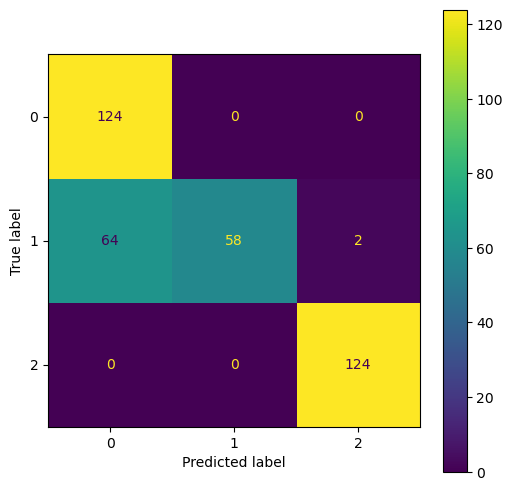

In [5]:
def eval_model_ds(model, test):
    # pass dataset directly into predict
    pred = model.predict(test, verbose=False);
    # do the usual thing to get the actual predictions rather than the softmax scores
    indexes = keras.ops.argmax(pred, axis=1)

    # pull out the labels. Here we loop throuhg all the data, and just concatenate the y values,
    # ditching the x values
    y_test = keras.ops.concatenate([y for x, y in test], axis=0)

    # and now we have our usual predictions and labels, and all is good
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[6, 6])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(3))
    c.plot(ax = ax)

    print(classification_report(y_test, indexes))

# evaluate our model
eval_model_ds(model, ds_test)

After our transfer learning pass the model is close to perfect on the training and validation data, but is not generalising all that well, with quite the drop in performance on the test set.

Let's now use fine-tuning to tweak the lot. Here all we have to do is set the base model to be trainable, then recompile and re-run fit. When we recompile, we'll use a very low learning rate to try and avoid overfitting too badly.

Epoch 1/2
142/142 ━━━━━━━━━━━━━━━━━━━━ 52s 162ms/step - accuracy: 0.7348 - loss: 0.7216 - val_accuracy: 0.9960 - val_loss: 0.0088
Epoch 2/2
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9294 - loss: 0.1930 - val_accuracy: 0.9960 - val_loss: 0.0207
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       124
           1       1.00      0.79      0.88       124
           2       1.00      1.00      1.00       124

    accuracy                           0.93       372
   macro avg       0.94      0.93      0.93       372
weighted avg       0.94      0.93      0.93       372



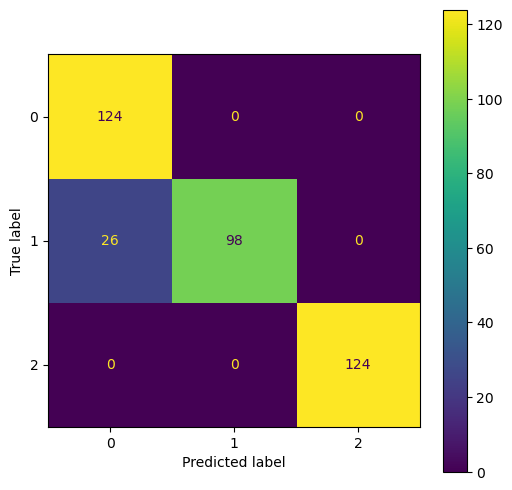

In [6]:
# set the base to now be trainable
base_model.trainable = True

# recompile - we need to do this as we're now training different things, so need to make keras aware of this
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(1e-5), metrics=['accuracy'], jit_compile=False)
# train again
history = model.fit(ds_train, batch_size=batch_size, epochs=2, validation_data=ds_val)

eval_model_ds(model, ds_test)

Our fine-tuning epochs are much slower. We're now tuning all the layers, not just a couple of little dense layers at the end. This itself is often a reason to avoid fine-tuning if you don't need to, though we can see that we'v got a nice little performance gain for our efforts (though this wont always be the case). To explain why we get this gain, consider what we're doing:
* In our first *transfer learning* stage, we're taking the representation that's been learnt on a different dataset, and using that as is. Essentially, we're hoping that all the information we need for our task is in that pre-existing representation.
* In our *fine tuning* stage, we're now allowing that pre-trained representation to change. So the network that we're using can be tweaked to extract features perfectly suited to the task at hand.